Jupyter notebook to perform a random forest classification on the extracted features
Written by Dominik Waibel & Niklas Kiermeyer

In [ ]:
#import dependencies
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import model_selection
from sklearn.metrics import precision_recall_fscore_support
import random
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import copy
from sklearn.preprocessing import PolynomialFeatures
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

## Required Folder Structure
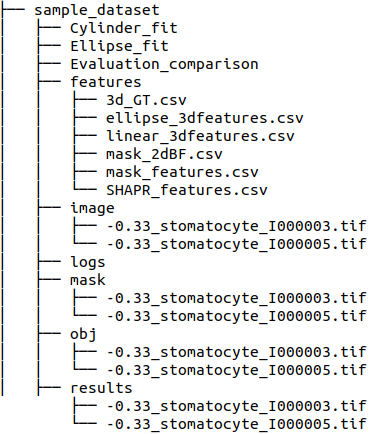


In [ ]:
##################################################################################
### Only change dataset and path, if you have the same folder structure as above.###
dataset = "blood_cell"
path = "/home/niklas/qscd/data/"
##################################################################################

path_results = path + dataset + "/results/"
path_features = path + dataset + "/features/"
save_path = path + dataset

data_mask = pd.read_csv("./features/mask_features.csv")
data_mask_bf = pd.read_csv("./features/mask_2dBF.csv")
data_obj = pd.read_csv("./features/SHAPR_features.csv")
data_ellipse = pd.read_csv("./features/ellipse_3dfeatures.csv")
data_linear = pd.read_csv("./features/linear_3dfeatures.csv")
data_gt = pd.read_csv("./features/3d_GT.csv")

data_mask_bf = data_mask_bf.rename(columns={'filename': 'filename_msk', 'mean': 'mean_BF', 'std': 'std_BF', 'gabor': 'gabor_BF', 'glcm_diss': 'glcm_diss_BF', 'glcm_cor': 'glcm_cor_BF'})


print(data_mask.shape)
print(data_obj.shape)
print(data_ellipse.shape)
print(data_linear.shape)

data_mask_bf = data_mask_bf.replace(np.nan, 0)

data_mask = data_mask.replace(np.nan, 0)
data_obj = data_obj.replace(np.nan, 0)
data_ellipse = data_ellipse.replace(np.nan, 0)
data_linear = data_linear.replace(np.nan, 0)
data_gt = data_gt.replace(np.nan, 0)

filenames = data_obj["filename"]

data_mask = data_mask.replace(np.nan, 0)
data_obj = data_obj.replace(np.nan, 0)
data_ellipse = data_ellipse.replace(np.nan, 0)
data_linear = data_linear.replace(np.nan, 0)




data_mask_bf = data_mask_bf.rename(columns={'filename': 'filename_msk', 'mean': 'mean_BF', 'std': 'std_BF', 'gabor': 'gabor_BF', 'glcm_diss': 'glcm_diss_BF', 'glcm_cor': 'glcm_cor_BF'})
data_2D = pd.merge(data_mask_bf, data_mask, on="filename_msk")
data_2D = data_2D.rename(columns={'filename_msk': 'filename'})

data_obj = pd.merge(data_obj, data_2D, on="filename")
data_linear = pd.merge(data_linear, data_2D, on="filename")
data_ellipse = pd.merge(data_ellipse, data_2D, on="filename")
data_gt = pd.merge(data_gt, data_2D, on="filename")

print(data_2D.shape)
print(data_obj.shape)
print(data_linear.shape)
print(data_ellipse.shape)
print(data_gt.shape)

In [ ]:
def get_labels(filenames):
    y = []
    for name in filenames:
        if "cluster" in name:
            y.append(0)
        elif "multi" in name: 
            y.append(2)
        elif "kera" in name: 
            y.append(3)
        elif "knizo" in name: 
            y.append(4)
        elif "acan" in name: 
            y.append(5)
        elif "sphero" or "stoma" or "disco" or "echino" in name:
            y.append(1)
    return y

y_obj = get_labels(data_obj["filename"])
y_2D = get_labels(data_2D["filename"])
y_ellipse = get_labels(data_ellipse["filename"])
y_linear = get_labels(data_linear["filename"])
y_gt = get_labels(data_gt["filename"])
print(y_obj)

In [ ]:
print(data_2D.shape)
print(data_obj.shape)
print(data_linear.shape)
print(data_ellipse.shape)
                                   
# Get headers
cols_mask = data_2D.columns
cols_obj = data_obj.columns
cols_ellipse = data_ellipse.columns                               
cols_linear = data_linear.columns 
cols_gt = data_gt.columns  
                                   
scaler1 = StandardScaler()
scaler1.fit(data_2D.drop("filename",1))
data_2D = pd.DataFrame(scaler1.transform(data_2D.drop("filename",1)))

scaler2 = StandardScaler()
scaler2.fit(data_obj.drop("filename",1))
data_obj = pd.DataFrame(scaler2.transform(data_obj.drop("filename",1)))

scaler3 = StandardScaler()
scaler3.fit(data_ellipse.drop("filename",1))
data_ellipse = pd.DataFrame(scaler3.transform(data_ellipse.drop("filename",1)))

scaler4 = StandardScaler()
scaler4.fit(data_linear.drop("filename",1))
data_linear = pd.DataFrame(scaler4.transform(data_linear.drop("filename",1)))

scaler5 = StandardScaler()
scaler5.fit(data_gt.drop("filename",1))
data_gt = pd.DataFrame(scaler5.transform(data_gt.drop("filename",1)))

In [ ]:
def random_forest(X, Y, name_prec_f1_av, confusion_name):
    clf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
    cv = ShuffleSplit(n_splits=5)
    cv = StratifiedShuffleSplit(n_splits = 5)
    results = []
    confusion_ypredict = []
    confusion_ytrue = []
    #print(Y)
    for i, (train, test) in enumerate(cv.split(X, Y)):
        clf = RandomForestClassifier(n_estimators = 2000, random_state = 42)
        
        ossampling_obj = SMOTE()
        X_train, Y_train = ossampling_obj.fit_resample(X[train], Y[train])
        
        clf.fit(X_train, Y_train.ravel())
        # Visually Compare predictions to GT class
        y_pred_os = clf.predict(X[test])
        confusion_ypredict.append(y_pred_os)
        confusion_ytrue.append(Y[test])
        results.append(precision_recall_fscore_support(Y[test], y_pred_os, average='weighted'))   
    print(results)

    results = np.asarray(results)
    res = results[:, 0:3]
    np.save(save_path + "/Evaluation_comparison/" + name_prec_f1_av + ".npy", res)
    print("Overall-mean")
    print(np.mean(res, axis=0))

    confusion_ypred = [item for sublist in confusion_ypredict for item in sublist]
    confusion_yt = [int(item) for sublist in confusion_ytrue for item in sublist]
    #print(confusion_ypred)
    #print(confusion_yt)
    sns.set(font_scale=1.2)

    cm = confusion_matrix(confusion_yt, confusion_ypred, labels=[0,1], normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])

    disp = disp.plot(cmap='Blues')
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None)
    #plt.savefig(save_path + "/classification_results_rf/" + dataset + "_" + confusion_name + ".png", dpi=300)
    plt.show()
    return confusion_ypredict, confusion_ytrue

In [ ]:
def remove_unimportant_features(dfX, dfY, thresold, cols):
    X_train, X_test, y_train, y_test = train_test_split(dfX, dfY, test_size=0.3, random_state=42)
    clf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
    
    ossampling_obj = SMOTE()
    X_train, y_train = ossampling_obj.fit_resample(X_train, y_train)
        
    clf.fit(X_train, y_train)
    y_pred_os = clf.predict(X_test)

    print(precision_recall_fscore_support(y_test, y_pred_os, average='micro')) 

    importance = clf.feature_importances_
    #print(np.mean(importance))
    
    feature_quantile_threshold = thresold #np.quantile(importance, 0.1)
    print("feature importance thresold", feature_quantile_threshold)
    upper_feature_quantile_threshold = np.quantile(importance, 0.8)
    # summarize feature importance
    unimportant_features = []

    for i, f in enumerate(importance):
        if np.abs(f) > upper_feature_quantile_threshold:
            print('Most important features:', str([cols[i]])+' , Score: ' + str(f))
        if np.abs(f) < feature_quantile_threshold:
            unimportant_features.append(dfX.columns.values[i])
    dfX_filtered = dfX.drop(columns=unimportant_features)
    print("input shape of features", dfX.shape, "output shape of features", dfX_filtered.shape)
    return dfX_filtered, importance

In [ ]:
print(data_2D.shape)
print(data_obj.shape)
print(data_linear.shape)
print(data_ellipse.shape)
print(data_gt.shape)

thresold = 0.015


mask_filtered_X, _ = remove_unimportant_features(data_2D, y_2D, thresold, cols_mask[1:])
obj_filtered_X, importance_obj = remove_unimportant_features(data_obj, y_obj, thresold, cols_obj[1:])
ellipse_filtered_X, _ = remove_unimportant_features(data_ellipse, y_ellipse, thresold, cols_ellipse[1:])
linear_filtered_X, _ = remove_unimportant_features(data_linear, y_linear, thresold, cols_linear[1:])
gt_filtered_X, importance_gt = remove_unimportant_features(data_gt, y_gt, thresold, cols_gt[1:])


In [ ]:
print(len(importance_gt))

In [ ]:
plt.figure(figsize=(10,4))
plt.bar(np.linspace(0, len(importance_obj), len(importance_obj)),importance_obj)
plt.bar(np.linspace(0, len(importance_gt), len(importance_gt))+0.1, importance_gt, alpha = 0.5)
plt.show()
print(cols_obj)

In [ ]:
for i, c in enumerate(cols_obj[1:]):
    print(i,c)

In [ ]:
confusion_ypredict_mask, confusion_ytrue_mask = random_forest(np.array(mask_filtered_X), np.array(y_2D), 'mask_precision_average_f1', 'mask')
confusion_ypredict_obj, confusion_ytrue_obj = random_forest(np.array(obj_filtered_X), np.array(y_obj), 'obj_precision_average_f1', 'obj')
_,_=random_forest(np.array(ellipse_filtered_X), np.array(y_ellipse), 'ellipse_precision_average_f1', 'ellipse')
_,_=random_forest(np.array(linear_filtered_X), np.array(y_linear), 'linear_precision_average_f1', 'linear')
_,_=random_forest(np.array(gt_filtered_X), np.array(y_gt), 'gt_precision_average_f1', 'gt')

In [ ]:
confusion_ypred = [item for sublist in confusion_ypredict_mask for item in sublist]
confusion_yt = [int(item) for sublist in confusion_ytrue_mask for item in sublist]
sns.set(font_scale=1.2)
cm = confusion_matrix(confusion_yt, confusion_ypred, labels=[0,1,2,3,4,5], normalize="true")
cm = np.round(cm,2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])

disp = disp.plot(cmap='Blues')
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

In [ ]:
confusion_ypred = [item for sublist in confusion_ypredict_obj for item in sublist]
confusion_yt = [int(item) for sublist in confusion_ytrue_obj for item in sublist]

sns.set(font_scale=1.2)
cm = confusion_matrix(confusion_yt, confusion_ypred, labels=[0,1,2,3,4,5], normalize="true")
cm = np.round(cm,2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5])

disp = disp.plot(cmap='Blues')
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.grid(b=None)
plt.show()

In [ ]:
# Create Boxplot for Performance Evaluation
mask = np.load(save_path + "/Evaluation_comparison/" + "mask_precision_average_f1.npy", allow_pickle=True)
obj = np.load(save_path + "/Evaluation_comparison/" + "obj_precision_average_f1.npy", allow_pickle=True)
ellipse = np.load(save_path + "/Evaluation_comparison/" + "ellipse_precision_average_f1.npy", allow_pickle=True)
linear = np.load(save_path + "/Evaluation_comparison/" + "linear_precision_average_f1.npy", allow_pickle=True)
gt = np.load(save_path + "/Evaluation_comparison/" + "gt_precision_average_f1.npy", allow_pickle=True)

df1 = pd.DataFrame(mask).assign(Method="mask")
df2 = pd.DataFrame(obj).assign(Method="obj")
df3 = pd.DataFrame(ellipse).assign(Method="ellipse")
df4 = pd.DataFrame(linear).assign(Method="linear")
df5 = pd.DataFrame(gt).assign(Method="gt")


df1.columns = ['Precision', 'Recall', 'F1', 'Method']
df2.columns = ['Precision', 'Recall', 'F1', 'Method']
df3.columns = ['Precision', 'Recall', 'F1', 'Method']
df4.columns = ['Precision', 'Recall', 'F1', 'Method']
df5.columns = ['Precision', 'Recall', 'F1', 'Method']

cdf = pd.concat([df1, df2, df3, df4, df5])#, df3])   
mdf = pd.melt(cdf, id_vars=['Method'], var_name=['Metric']) 

sns.set_style("ticks")
ax_plot = sns.boxplot(x="Metric", y="value", hue="Method", data=mdf)
plt.figure(1, figsize=(14,14))
plt.legend(loc=(1.04,0.75))
plt.show()

# Save Boxplot. BBox_inches tight so that legend is not cut off when saving plot
ax_plot.grid(False)
#ax_plot.figure.savefig(save_path + "/classification_resultsrf/" + "boxplot_" + dataset + ".png", bbox_inches='tight', dpi=300)

In [ ]:
df1 = pd.DataFrame(mask[:,2]).assign(Method="mask")
df2 = pd.DataFrame(obj[:,2]).assign(Method="obj")
df3 = pd.DataFrame(linear[:,2]).assign(Method="linear")
df4 = pd.DataFrame(ellipse[:,2]).assign(Method="ellipse")
df5 = pd.DataFrame(gt[:,2]).assign(Method="gt")


print("f1")
print(np.mean(mask[:,2])*100,np.std(mask[:,2])*100)
print(np.mean(obj[:,2])*100,np.std(obj[:,2])*100)
print(np.mean(linear[:,2])*100,np.std(linear[:,2])*100)
print(np.mean(ellipse[:,2])*100,np.std(ellipse[:,2])*100)
print(np.mean(gt[:,2])*100,np.std(gt[:,2])*100)


from scipy.stats import wilcoxon, ks_2samp, mannwhitneyu, ranksums
#print("mask, obj", mannwhitneyu(mask[:,2], obj[:,2]))
print("mask, comb", wilcoxon(np.array(obj[:,2]),np.array(mask[:,2])))
print("obj, comb", wilcoxon(mask[:,2], obj[:,2]))
#benchmark = pd.DataFrame(benchmark).assign(Method="benchmark")
#calculate mean to plot bar symbol

mask_mean = np.mean(df1)
obj_mean = np.mean(df2)
linear_mean = np.mean(df3)
ellipse_mean = np.mean(df4)
gt_mean = np.mean(df5)

df1.columns = ['F1', 'Method']
df2.columns = ['F1', 'Method']
df3.columns = ['F1', 'Method']
df4.columns = ['F1', 'Method']
df5.columns = ['F1', 'Method']
#benchmark.columns = ['Precision', 'Recall', 'F1', 'Method']
cdf = pd.concat([df1, df2, df3, df4, df5])
mdf = pd.melt(cdf, id_vars=['Method'], var_name=['Metric']) 
sns.set_style("ticks")
#ax_plot = sns.boxplot(x="Method", y="F1", data=cdf)
ax_plot= sns.swarmplot(x="Method", y = "F1",data=cdf, color=".25",s=7)

plt.plot((-0.2,.2),(mask_mean,mask_mean), c = "black")
plt.plot((0.8,1.2),(obj_mean,obj_mean), c = "black")
plt.plot((1.8,2.2),(linear_mean,linear_mean), c = "black")
plt.plot((2.8,3.2),(ellipse_mean,ellipse_mean), c = "black")
plt.plot((3.8,4.2),(gt_mean,gt_mean), c = "black")
plt.locator_params(axis='y', nbins=4)
#ax_plot.set_ylim([0.8,1])
plt.show()

In [ ]:
thresholds = [0.02, 0.015, 0.01, 0.005, 0.001]
number_features_left = []
f1_score = []
for threshold in thresholds: 
    obj_filtered_X, importance = remove_unimportant_features(data_obj, y_obj, threshold, cols_obj)
    number_features_left.append(np.shape(obj_filtered_X))
    random_forest(np.array(obj_filtered_X), np.array(y_obj), 'obj_precision_average_f1_thresold_' + str(threshold), 'obj')